# Logistic Regression
# Scaling
# Hyperparameter Tuning

In this notebook you will see a short example of how to select a model, scale your data and tune the hyperparamters of your models using grid or random search.  

We will use the titanic dataset.  
Since you've already worked your way through the steps of exploring and cleaning the data as well as selecting proper features for modelling in another notebook, we will skip this part here and use the **preprocessed data** from the logistic regression notebook. 

In [ ]:
# Import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

# set seaborn plot style
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")
RSEED = 10

What about a person's name, ticket number, and passenger ID number? For now they're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [4]:
# Import data 
df = pd.read_csv('data/titanic_preprocessed.csv')
df.head(2)

,Survived,Age,SibSp,Parch,Fare,male,Q,S
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0


In [5]:
#... or we could reload the stored titanic_dmy from the other notebook
# %store -r titanic_dmy
# titanic_dmy.head(2)

But in this notebook, we will use the preprocessed data from the titanic_preprocessed.csv!

In [6]:
# Check for missing data
df.isnull().sum()

Survived    0
Age         0
SibSp       0
Parch       0
Fare        0
male        0
Q           0
S           0
dtype: int64

## Train-Test-Split

Train-Test-Split splits arrays or matrices, also for example our dataframe, into random train and test subsets.  
The main idea of splitting the dataset into a validation set is to prevent our model from overfitting i.e., the model becomes really good at classifying the samples in the training set but cannot generalize and make accurate classifications on the data it has not seen before.  

We will define the target and predictors and split our dataset into a train and test set.

In [7]:
# Define predictors and target
y = df.Survived
X = df.drop('Survived', axis=1)

In [8]:
df.head(2)

,Survived,Age,SibSp,Parch,Fare,male,Q,S
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0


In [9]:
# Check Y
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [10]:
# Check X
X.head(2)

,Age,SibSp,Parch,Fare,male,Q,S
0,22.0,1,0,7.2500,1,0,1
1,38.0,1,0,71.2833,0,0,0


In [11]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
for set in (X_train, X_test, y_train, y_test):
    print(set.shape)

(711, 7)
(178, 7)
(711,)
(178,)


## Logistic Regression in scikit-learn

In [13]:
#import Logistic Regression classifier from sklearn
from sklearn.linear_model import LogisticRegression

So, how easy is it to make some predictions now?

In [14]:
classifier = LogisticRegression() # instantiate a sklearn logistic regression classs
classifier.fit(X_train, y_train) # fit the classifier/model on our train data 
y_prediction = classifier.predict(X_test) # use the fit model to predict on our test data 

#have a look at the predicitons
y_prediction[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0])

In [15]:
y_test

159    0
125    0
427    0
421    0
564    0
      ..
39     1
90     0
881    0
851    1
636    0
Name: Survived, Length: 178, dtype: int64

## Model performance metrics
example 1: confusion matrix

In [16]:
cm = confusion_matrix(y_test, y_prediction, labels=[0,1]) # assign a confusion matrix that compares test data and predictions 
cm

array([[97, 13],
       [25, 43]])

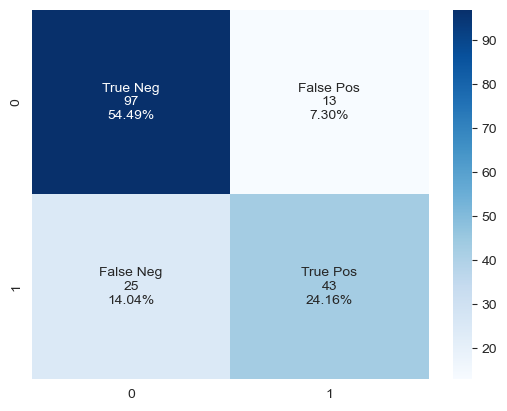

In [17]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');

In this labels parameter sequence, the matrix horizontally reads the "predicted" and vertically the "actual" labels,  
so in the first line True Negatives, False Positives and in the second line False Negatives and True Positives.  
The results from the confusion matrix are telling us that 97 and 43 are the number of correct predictions. 13 and 25 are the number of incorrect predictions.

sklearn classifikation report

In [18]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.77      0.63      0.69        68

    accuracy                           0.79       178
   macro avg       0.78      0.76      0.76       178
weighted avg       0.78      0.79      0.78       178



__Precision__ is the accuracy of positive predictions:  
Precision = TP/(TP + FP)  
  
__Recall__ tells you what percent of the positive cases did you in fact catch?  
The fraction of positives that were correctly identified:  
Recall = TP/(TP+FN)

**Let us learn about Classification Report: https://muthu.co/understanding-the-classification-report-in-sklearn/**

## Model selection

1. import all the classifiers you want to evaluate

In [19]:
#import all the classifiers you want to evaluate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

2. append them to a list

In [20]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(random_state=RSEED)))

In [21]:
models

[('LR', LogisticRegression()),
 ('LDA', LinearDiscriminantAnalysis()),
 ('KNN', KNeighborsClassifier()),
 ('NB', GaussianNB()),
 ('SVM', SVC(gamma='auto')),
 ('SGD', SGDClassifier(random_state=10))]

3. iterate over the list and get a performance metric for every model  
(here, we chose "accuracy", the ratio of the number of correctly classified cases to the total of cases under evaluation - but it could be based on every other perfomance metric)

In [22]:

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.787598 (0.057963)
LDA: 0.786228 (0.061278)
KNN: 0.689143 (0.032614)
NB: 0.767899 (0.052163)
SVM: 0.700313 (0.051654)
SGD: 0.662520 (0.059925)


Based on these results, we move on with the Linear Regression Classifier

---
## Features Scaling

Often the input features of your model have different units which means that the variables also have different scales. While some model types (e.g. tree-based models like decision tree or random forest) are unaffected by the scale of numerical input variables, many machine learning algorithms including for example algorithms using distance measures (e.g. KNN, SVM) perform better when the input features are scaled to a specific range. 

The most popular techniques for scaling are **normalization** and **standardization**. 

Chech the [link](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/) for further info. 

![scaling](images/normalization_vs_standardization.png)

In [23]:
# Before we have a look at the different methods, 
# we have to define which columns we want to scale.
display(df.describe().round(2))
col_scale = ['Age', 'SibSp', 'Parch', 'Fare']

,Survived,Age,SibSp,Parch,Fare,male,Q,S
count,889.00,889.00,889.00,889.00,889.00,889.00,889.00,889.00
mean,0.38,29.02,0.52,0.38,32.10,0.65,0.09,0.72
std,0.49,13.21,1.10,0.81,49.70,0.48,0.28,0.45
min,0.00,0.42,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,22.00,0.00,0.00,7.90,0.00,0.00,0.00
50%,0.00,26.00,0.00,0.00,14.45,1.00,0.00,1.00
75%,1.00,36.50,1.00,0.00,31.00,1.00,0.00,1.00
max,1.00,80.00,8.00,6.00,512.33,1.00,1.00,1.00


### Data Standardization 

In order to standardize a dataset it is necessary to rescale the distribution of values so that the mean of observed values is 0 and the standard deviation is 1. You can think of it as subtracting the mean value or centering the data. 
Sklearn provides us for this case with the [Standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

A value is standardized as follows: 


$ x_{scaled} = \frac{x – \mu}{\sigma}  $, where 

$ \mu = \frac{\sum{x}}{m} $ is the mean, where m is the number of observations

$ \sigma = \sqrt{ \frac{\sum{ (x – \mu)^2 }}{m}} $ is the standard deviation



In [24]:
# Scaling with standard scaler
# the fit part method is calculating the mean and the variance of the data
# fit_transform applies this to transform all the features in respect to that values
# transform applies this to new data in respect to that already learned values, not the new data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

In [25]:
X_train_preprocessed

array([[ 0.97119698,  0.46976084, -0.4614951 , ...,  1.        ,
         0.        ,  1.        ],
       [-0.01084571, -0.46844129, -0.4614951 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.59348825, -0.46844129, -0.4614951 , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.42444745,  0.46976084,  3.14425233, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.3489057 , -0.46844129, -0.4614951 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.59348825, -0.46844129, -0.4614951 , ...,  1.        ,
         0.        ,  1.        ]])

### Data normalization 

Normalizing the data means to rescale it from the original range so that all values lie within the new range of 0 and 1.
We can easily do this by using the [Min-Max-Scaler](https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. This scaler transforms the feature(s) by scaling it(them) to a given range (default range is 0 to 1). 

A value is normalized as follows: 

$ x_{scaled} = \frac{x – x_{min}}{x_{max} – x_{min}} $

(Where the min and max values pertain to the value x being normalized, from your **train** dataset)

In [26]:
# Scaling with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [27]:
# Define predictors and target
y2 = df.Survived
X2 = df.drop('Survived', axis=1)

In [28]:
# Train-test-split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

In [29]:
# Before we have a look at the different methods, 
# we have to define which columns we want to scale.
col_scale = ['Age', 'SibSp', 'Parch', 'Fare']

In [30]:
# Scaling with minmax scaler
mmscaler = MinMaxScaler()
X2_train_scaled = mmscaler.fit_transform(X2_train[col_scale])
X2_test_scaled = mmscaler.transform(X2_test[col_scale])

In [31]:
# Concatenating scaled and dummy columns
X2_train_preprocessed = np.concatenate([X2_train_scaled, X2_train.drop(col_scale, axis=1)], axis=1)
X2_test_preprocessed = np.concatenate([X2_test_scaled, X2_test.drop(col_scale, axis=1)], axis=1)

In [32]:
print("test", pd.DataFrame(X2_train_preprocessed).describe())
print("---")
print("train", pd.DataFrame(X2_test_preprocessed).describe())

test                 0           1           2           3           4           5  \
count  711.000000  711.000000  711.000000  711.000000  711.000000  711.000000   
mean     0.358279    0.062412    0.063994    0.062181    0.644163    0.082982   
std      0.167155    0.133327    0.138765    0.096310    0.479103    0.276049   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.268139    0.000000    0.000000    0.015412    0.000000    0.000000   
50%      0.318612    0.000000    0.000000    0.028107    1.000000    0.000000   
75%      0.457413    0.125000    0.000000    0.059532    1.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

                6  
count  711.000000  
mean     0.734177  
std      0.442081  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  
---
train                 0           1           2           3           4          

---
## Predictive Modelling

We will evaluate our model performance with a quick and more reliable way using sklearn's [cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) which implements K-fold cross validation. When training a model based on train and test split we only have one experiment. Can we really trust one experiment? 

Think of [K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) as doing K experiments and then taking the average error. It is still not perfect but better than 1 experiment which can randomly turn out to be really good. 

Whenever we have K, comes the question about the value of K.. common values are between 5 and 10 and you need to take into account the technical limitations: dataset size, compute power and available memory and time. CV takes time on large datasets.


![cv](images/cross_validation.png)

### LogisticRegression Classifier - unscaled data

In [33]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
logreg_classifier = LogisticRegression()
scores = cross_val_score(logreg_classifier, X_train, y_train, cv=5, n_jobs=-1, verbose=5) 

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 4));

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................ score: (test=0.776) total time=   0.0s
[CV] END ................................ score: (test=0.789) total time=   0.0s
[CV] END ................................ score: (test=0.775) total time=   0.0s
[CV] END ................................ score: (test=0.782) total time=   0.0s
[CV] END ................................ score: (test=0.803) total time=   0.0s
Score (unscaled): 0.7848


/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.1s
/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer

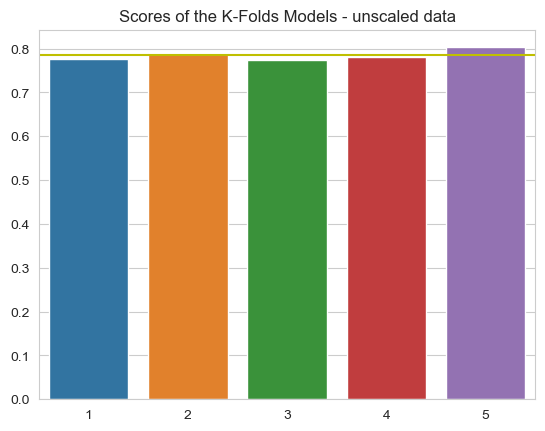

In [34]:
# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4,5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

### LogisticRegression Classifier - standardized scaled data

In [35]:
# Fit and evaluate model using cross validation and scaled data 
logreg_scaled = LogisticRegression()
scores_scaled_std = cross_val_score(logreg_scaled, X_train_preprocessed, y_train, cv=5, n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled_std.mean(), 4))

Score (scaled): 0.7834


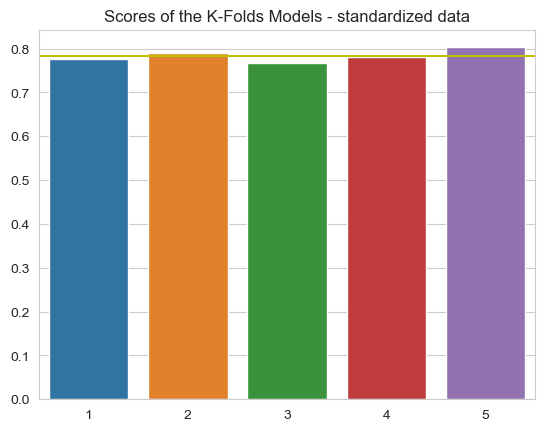

In [36]:
plt.axhline(y=scores_scaled_std.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4,5],y=scores_scaled_std).set_title('Scores of the K-Folds Models - standardized data');

The model errors on standardized features have a slightly bigger standard deviation than on non-scaled features.

### LogisticRegression Classifier - normalized scaled data

Score (scaled): 0.7919


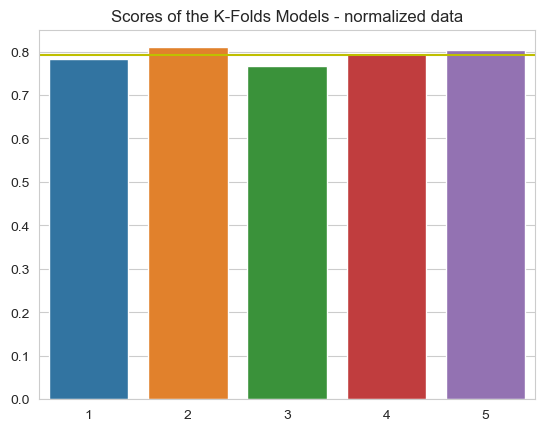

In [37]:
# Fit and evaluate model using cross validation and scaled data 
log_reg_scaled = LogisticRegression()
scores_scaled_norm = cross_val_score(log_reg_scaled, X2_train_preprocessed, y_train, cv=5, n_jobs=-1, scoring='accuracy')
# If "scoring"=None, the estimator’s default scorer (if available) is used.

# Evaluation
print('Score (scaled):', round(scores_scaled_norm.mean(), 4))

plt.axhline(y=scores_scaled_norm.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores_scaled_norm).set_title('Scores of the K-Folds Models - normalized data');

In [38]:
print('Score (unscaled):', round(scores.mean(), 4))
print('Score (scaled, standardized):', round(scores_scaled_std.mean(), 4))
print('Score (scaled, normalized):', round(scores_scaled_norm.mean(), 4))


Score (unscaled): 0.7848
Score (scaled, standardized): 0.7834
Score (scaled, normalized): 0.7919


Based on these first results, we'd go for normalized data!  
But can we improve even better?


---
## Hyperparameter Tuning

Most models have many parameters that work better with some datasets than with others. Same goes with the parameters from regularization which we learned that are selected based on a trial and error process. So how do we deal selecting the parameter values that work best for our data?

#### GridSearchCV

[Grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is a tuning technique that attempts to compute the optimum values of hyperparameters. It performs an exhaustive search over a prior defined parameter space using cross-validation (hence the **CV** suffix). That means it will evaluate all of the possible parameter combinations of the search space in order to find and return the best combination. 


This task, however, starts to become very time-consuming if there are many hyperparameters and the search space is huge. As you can see for k= 5 and for 2 parameters with 2, and respectively 3 values, thus 6 combinations, the GridSearcCV runs 30 modeling steps in order to just come up with the best values for the two parameters.

![grid search](images/grid_search_cv.png)  

In [39]:
#what parameters does sklearn.linear_model.LogisticRegression() have?
logreg_classifier.get_params()#.keys()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [40]:
# Defining parameter grid (as dictionary)
param_grid = {"solver" : ["lbfgs", "liblinear", "newton-cg", "sag", "saga"],
              "penalty" : ["l2", "l1", "elasticnet"],
              "fit_intercept" : [True, False]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(logreg_classifier, param_grid, scoring='accuracy',
                  cv=5, verbose=1)

# Fit gridsearch object to data. Also lets see how long it takes.
start = timer()
gs.fit(X2_train_preprocessed, y_train)
end = timer()
gs_time = end-start

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [41]:
# Best score
print('Best score:', round(gs.best_score_, 3))
print('Score (scaled, normalized):', round(scores_scaled_norm.mean(), 3)) #cross validation score from normalized data

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.793
Score (scaled, normalized): 0.792
Best parameters: {'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


In [42]:
# we will do this at least twice.. according to DRY we should write a function
def print_pretty_summary(name, model, y_test, y_pred_test):
    print(name)
    print('=======================')
    print('solver: {}'.format(model.solver))
    print('fit_intercept: {}'.format(model.fit_intercept))
    print('penalty: {}'.format(model.penalty))
    accuracy = accuracy_score(y_test, y_pred_test)
    print('Test accuracy: {:2f}'.format(accuracy))
    return accuracy

In [43]:
# Assigning the fitted LogRegClassifier model with best parameter combination to a new variable logreg_best
logreg_best = gs.best_estimator_

# Making predictions on the test set
y_pred_test_gs = logreg_best.predict(X2_test_preprocessed)
# Let us print out the performance of our model on the test set.
gs_accuracy = print_pretty_summary('LogReg Classifier model', logreg_best, y_test, y_pred_test_gs)

LogReg Classifier model
solver: liblinear
fit_intercept: True
penalty: l2
Test accuracy: 0.780899


In [44]:
#Have a look at the confusion matrix below
confusion_matrix(y_test, y_pred_test_gs)

array([[95, 15],
       [24, 44]])

#### [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

As an alternative to grid search we can use sklearn's RandomizedSearchCV(). Random search will not try every possible combination of our search space but will randomly pick and evaluate parameter combinations. 

In [45]:
# Define paramter grid for randomized search
param_grid = {"solver" : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
              "penalty" : ["l2", "l1", "elasticnet"],
              "multi_class" : ["auto", "ovr", "multinomial"],
              "fit_intercept" : [True, False]
             }

# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(logreg_classifier, param_grid, scoring='accuracy',
                  cv=5, verbose=1, n_jobs=-1, n_iter=4)

# Fit randomized search object to data
start = timer()
rs.fit(X2_train_preprocessed, y_train)
end = timer()
rgs_time = end-start

Fitting 5 folds for each of 4 candidates, totalling 20 fits


ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver newton-cholesky supports only 'l2' or 'none' penalties, got elasticnet penalty.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/utils/parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 521, in _logistic_regression_path
    alpha = (1.0 / C) * (1 - l1_ratio)
TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/matthiasmotl/opt/anaconda3/envs/nf_sql2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.


In [ ]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

Best score: 0.783
Best parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'fit_intercept': False}


In [ ]:
# Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
logreg_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = logreg_best_rs.predict(X2_test_preprocessed)


# Let us print out the performance of our model on the test set.
rs_accuracy = print_pretty_summary('LogReg Classifier model (randomizedGSCV)', logreg_best_rs, y_test, y_pred_test_rs)

LogReg Classifier model (randomizedGSCV)
solver: lbfgs
fit_intercept: False
penalty: l2
Test accuracy: 0.764045


In [ ]:
print(f"Grid search took {gs_time} seconds to run with accuracy: {gs_accuracy:f}")
print(f"Randomized Grid search took {rgs_time} seconds to run with accuracy: {rs_accuracy:f}")

Grid search took 0.23115379099999878 seconds to run with accuracy: 0.780899
Randomized Grid search took 0.04464604200000011 seconds to run with accuracy: 0.764045


In [ ]:
#confusion matrix for the grid search
cm_final = confusion_matrix(y_test, y_pred_test_gs)
cm_final

array([[95, 15],
       [24, 44]])

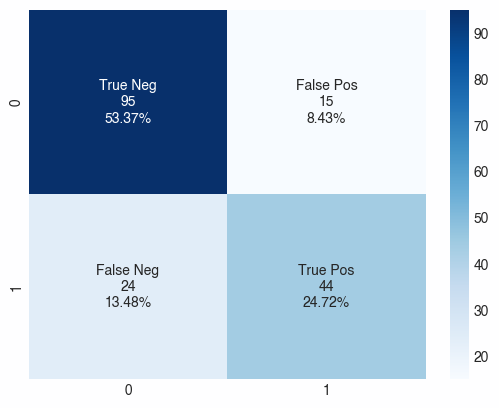

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_final.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_final.flatten()/np.sum(cm_final)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_final, annot=labels, fmt='', cmap='Blues');

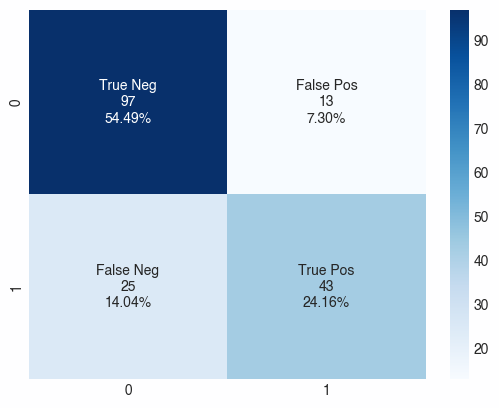

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');